In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata #need to use pip install sodapy to get this, using it to get data from the CDC website
import os

data_prefix = 'Data/'
output_prefix_01 = '01_data_processing.ipynb.output/'

## Getting Data

In [263]:
#make a Data folder if one doesn't exist
if not os.path.exists(data_prefix):
    os.makedirs(data_prefix)

#check if the data files exist, otherwise pull from the CDC website
if not os.path.exists(data_prefix + 'covid_rates.csv'):
    print('Downloading data from CDC website')
    ## pulling data from CDC website using Socrata API
    # Create a client object
    client = Socrata("data.cdc.gov", None)

    # pull rsv, covid, and flu rates data https://data.cdc.gov/Public-Health-Surveillance/Rates-of-Laboratory-Confirmed-RSV-COVID-19-and-Flu/kvib-3txy/about_data
    covid_rates_results = client.get("kvib-3txy",limit=47333)
    # Convert to pandas DataFrame
    covid_rates_df = pd.DataFrame.from_records(covid_rates_results)
    #pull youth obesity data https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Youth-Risk/vba9-s8jp/about_data
    youth_results = client.get("vba9-s8jp", limit=50092)
    # Convert to pandas DataFrame
    youth_df = pd.DataFrame.from_records(youth_results)
    #pull adult obesity data https://chronicdata.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7/about_data
    adult_results = client.get("hn4x-zwk7", limit=104272)
    # Convert to pandas DataFrame
    adult_df = pd.DataFrame.from_records(adult_results)

    #download the data into the data folder
    covid_rates_df.to_csv(data_prefix + 'covid_rates.csv', index=False)
    youth_df.to_csv(data_prefix + 'youth_obesity.csv', index=False)
    adult_df.to_csv(data_prefix + 'adult_obesity.csv', index=False)
else:
    print('Data already downloaded')
    #read in the data
    covid_rates_df = pd.read_csv(data_prefix + 'covid_rates.csv')
    youth_df = pd.read_csv(data_prefix + 'youth_obesity.csv')
    adult_df = pd.read_csv(data_prefix + 'adult_obesity.csv')


Data already downloaded


In [264]:
print(youth_df.columns)
print(adult_df.columns)

Index(['yearstart', 'yearend', 'locationabbr', 'locationdesc', 'datasource',
       'class', 'topic', 'question', 'data_value_type', 'data_value',
       'data_value_alt', 'low_confidence_limit', 'high_confidence_limit',
       'sample_size', 'race_ethnicity', 'geolocation', 'classid', 'topicid',
       'questionid', 'datavaluetypeid', 'locationid',
       'stratificationcategory1', 'stratification1',
       'stratificationcategoryid1', 'stratificationid1', 'total', 'grade',
       'sex', 'data_value_footnote_symbol', 'data_value_footnote'],
      dtype='object')
Index(['yearstart', 'yearend', 'locationabbr', 'locationdesc', 'datasource',
       'class', 'topic', 'question', 'data_value_unit', 'data_value_type',
       'data_value', 'data_value_alt', 'low_confidence_limit',
       'high_confidence_limit', 'sample_size', 'race_ethnicity', 'geolocation',
       'classid', 'topicid', 'questionid', 'datavaluetypeid', 'locationid',
       'stratificationcategory1', 'stratification1',
      

## Data Processing

In [265]:
# #fixing values in the 'Race/Ethnicity' column
# #there are two years where some of the answers are not capitalized but should be part of the same category
# youth_df['Race/Ethnicity'] = youth_df['Race/Ethnicity'].replace('non-Hispanic black', 'Non-Hispanic Black')
# youth_df['Race/Ethnicity'] = youth_df['Race/Ethnicity'].replace('non-Hispanic white', 'Non-Hispanic White')

In [266]:
#transforming youth dataframe
#pivotting the dataframe so that each row for a given year and location, and each column is the average value for different demographics for that metric
youth_df_very_wide = youth_df.pivot_table(index=['yearstart','locationabbr','geolocation'],columns=['class',"stratificationid1"],values="data_value")
#change the index to columns
youth_df_very_wide.reset_index(inplace=True)
#smoosh the column index
youth_df_very_wide.columns = ['_'.join(col).strip() for col in youth_df_very_wide.columns.values]
#replace whitespace with underscores
youth_df_very_wide.columns = youth_df_very_wide.columns.str.replace(' ', '')
#remove trailing underscores
youth_df_very_wide.columns = youth_df_very_wide.columns.str.rstrip('_')

#add a prefix 'Youth' to all columns except for the first three
youth_df_very_wide.columns = ['youth_' + col if col not in ['yearstart','locationabbr','geolocation'] else col for col in youth_df_very_wide.columns]

#split the data in the geolocation column into two columns, 'latitude' and 'longitude', I tried doing this by transforming the dictionaries in this column but couldn't figure it out
#the geolocation column is a string that starts like this: "{'latitude': '37.7749', 'longitude': '-122.4194'}"
youth_df_very_wide["latitude"] = youth_df_very_wide['geolocation'].str.split(',', expand=True)[0].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
youth_df_very_wide["longitude"] = youth_df_very_wide['geolocation'].str.split(',', expand=True)[1].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
#drop the geolocation column
youth_df_very_wide.drop(columns=['geolocation'], inplace=True)
#move the latitude and longitude columns to the front
cols = youth_df_very_wide.columns.tolist()
cols = cols[-2:] + cols[:-2]
youth_df_very_wide = youth_df_very_wide[cols]


#transform adult dataframe
#pivotting the dataframe so that each row for a given year and location, and each column is the average value for different demographics for that metric
adult_df_very_wide = adult_df.pivot_table(index=['yearstart','locationabbr','geolocation'],columns=['class',"stratificationid1"],values="data_value")
#change the index to columns
adult_df_very_wide.reset_index(inplace=True)
#smoosh the column index
adult_df_very_wide.columns = ['_'.join(col).strip() for col in adult_df_very_wide.columns.values]
#replace whitespace with underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.replace(' ', '')
#remove trailing underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.rstrip('_')
#add a prefix 'Adult' to all columns except for the first three
adult_df_very_wide.columns = ['adult_' + col if col not in ['yearstart','locationabbr','geolocation'] else col for col in adult_df_very_wide.columns]
#split the data in the geolocation column into two columns, 'latitude' and 'longitude', I tried doing this by transforming the dictionaries in this column but couldn't figure it out
#the geolocation column is a string that starts like this: "{'latitude': '37.7749', 'longitude': '-122.4194'}"
adult_df_very_wide["latitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[0].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
adult_df_very_wide["longitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[1].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
#drop the geolocation column
adult_df_very_wide.drop(columns=['geolocation'], inplace=True)

#move the latitude and longitude columns to the front
cols = adult_df_very_wide.columns.tolist()
cols = cols[-2:] + cols[:-2]
adult_df_very_wide = adult_df_very_wide[cols]

#merge the two dataframes on YearStart and LocationAbbr
full_df_very_wide = pd.merge(youth_df_very_wide, adult_df_very_wide, on=['yearstart','locationabbr','latitude','longitude'], how='outer')

#replace / in column names with _
full_df_very_wide.columns = full_df_very_wide.columns.str.replace('/', '')


full_df_very_wide.head()

,latitude,longitude,yearstart,locationabbr,youth_FruitsandVegetables_FEMALE,youth_FruitsandVegetables_GRADE09,youth_FruitsandVegetables_GRADE10,youth_FruitsandVegetables_GRADE11,youth_FruitsandVegetables_GRADE12,youth_FruitsandVegetables_MALE,...,adult_PhysicalActivity_MALE,adult_PhysicalActivity_OVERALL,adult_PhysicalActivity_RACE2PLUS,adult_PhysicalActivity_RACEASN,adult_PhysicalActivity_RACEBLK,adult_PhysicalActivity_RACEHIS,adult_PhysicalActivity_RACEHPI,adult_PhysicalActivity_RACENAA,adult_PhysicalActivity_RACEOTH,adult_PhysicalActivity_RACEWHT
0,32.840571,-86.631861,2001,AL,49.95,52.75,50.80,50.05,44.30,49.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.748650,-92.274491,2001,AR,43.25,41.35,43.90,40.95,44.35,42.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39.008831,-75.577741,2001,DE,33.50,34.10,31.95,34.55,30.85,32.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28.932040,-81.928961,2001,FL,41.05,40.80,40.25,40.20,44.65,41.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43.682630,-114.363730,2001,ID,34.70,35.50,37.75,33.05,38.00,37.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
#cleaning up data

#remove even years, the youth data is only for odd years
full_df_very_wide = full_df_very_wide[full_df_very_wide['yearstart'].astype(int) % 2 == 1]
#remove years before 2011, the adult data is only from 2011 and later
full_df_very_wide = full_df_very_wide[full_df_very_wide['yearstart'].astype(int) >= 2011]
#remove the year 2023, not all data is available for this year
full_df_very_wide = full_df_very_wide[full_df_very_wide['yearstart'].astype(int) != 2023]

#remove rows that are missing more than 40% of the data
threshold = len(full_df_very_wide.columns) * 0.6
full_df_very_wide = full_df_very_wide.dropna(thresh=threshold)

#remove rows that are missing data in adult_ObesityWeightStatus_OVERALL
full_df_very_wide = full_df_very_wide.dropna(subset=['adult_ObesityWeightStatus_OVERALL'])
#remove all columsn that start with 'adult_ObesityWeightStatus' except for the overall one
adult_obesity_cols = [col for col in full_df_very_wide.columns if col.startswith('adult_ObesityWeightStatus') and col != 'adult_ObesityWeightStatus_OVERALL']
full_df_very_wide.drop(columns=adult_obesity_cols, inplace=True)
print(full_df_very_wide.shape)
#print counts of nas for each column
print(full_df_very_wide.isna().sum())

#value counts for locationabbr
print(full_df_very_wide['locationabbr'].value_counts())
#remove rows with locationabbr = 'US'
full_df_very_wide = full_df_very_wide[full_df_very_wide['locationabbr'] != 'US']
#remove locations with less than 6 data points (6 time points from 2011-2021)
location_counts = full_df_very_wide['locationabbr'].value_counts()
locations_to_remove = location_counts[location_counts < 6].index.tolist()
full_df_very_wide = full_df_very_wide[~full_df_very_wide['locationabbr'].isin(locations_to_remove)]



(235, 131)
latitude                              0
longitude                             0
yearstart                             0
locationabbr                          0
youth_FruitsandVegetables_FEMALE     12
                                   ... 
adult_PhysicalActivity_RACEHIS        7
adult_PhysicalActivity_RACEHPI      227
adult_PhysicalActivity_RACENAA       74
adult_PhysicalActivity_RACEOTH      151
adult_PhysicalActivity_RACEWHT        3
Length: 131, dtype: int64
locationabbr
CT    6
AR    6
KY    6
MA    6
MD    6
IL    6
VA    6
RI    6
SC    6
TN    6
NY    6
OK    6
NE    6
NM    6
NC    6
MT    6
MI    6
ME    6
NV    5
ND    5
MO    5
AL    5
TX    5
WI    5
VT    5
KS    5
FL    5
DE    5
AK    5
MS    5
HI    4
GA    4
IA    4
LA    4
PA    4
AZ    4
ID    4
OH    4
NH    4
DC    3
IN    3
NJ    3
SD    3
UT    3
WY    3
CA    3
GU    3
CO    3
PR    3
WV    1
Name: count, dtype: int64


(array([ 1.,  1.,  4.,  2.,  6.,  2.,  5.,  4.,  4., 13., 11., 16.,  6.,
         3.,  7.,  6.,  5.,  6.,  2.,  4.]),
 array([29.   , 29.355, 29.71 , 30.065, 30.42 , 30.775, 31.13 , 31.485,
        31.84 , 32.195, 32.55 , 32.905, 33.26 , 33.615, 33.97 , 34.325,
        34.68 , 35.035, 35.39 , 35.745, 36.1  ]),
 <BarContainer object of 20 artists>)

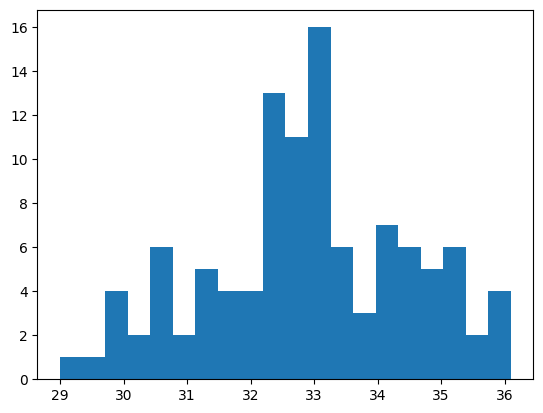

In [268]:
full_df_very_wide['adult_ObesityWeightStatus_OVERALL']
#histogram of the adult obesity data
plt.hist(full_df_very_wide['adult_ObesityWeightStatus_OVERALL'], bins=20)

In [269]:
#calculate column means grouped by location
group_means = full_df_very_wide.groupby('locationabbr').mean()
#fill missing values with the mean of the column, matching locationabbr
for location in group_means.index:
    for col in group_means.columns:
        #check if the location is in the dataframe
        if location in full_df_very_wide['locationabbr'].values:
            #check if the column is in the dataframe
            if col in full_df_very_wide.columns:
                #fill missing values with the mean of the column
                full_df_very_wide.loc[full_df_very_wide['locationabbr'] == location, col] = full_df_very_wide.loc[full_df_very_wide['locationabbr'] == location, col].fillna(group_means.loc[location, col])

#remove columns with any nas
full_df_very_wide.dropna(axis=1, how='any', inplace=True)
full_df_very_wide.shape

(108, 93)

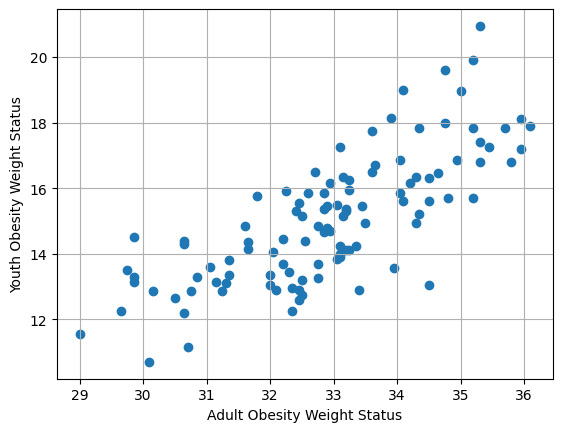

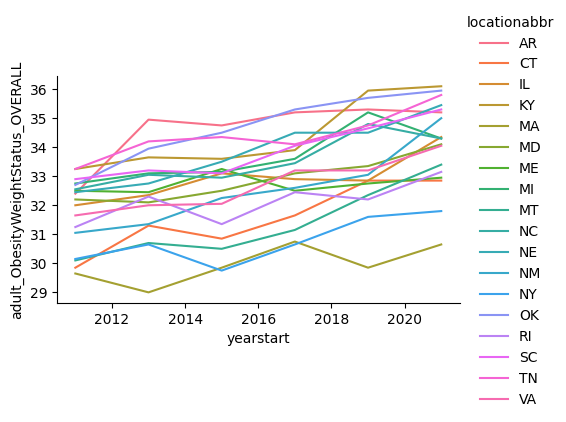

In [270]:
#plot a scatterplot of the adult obesity data and youth obesity data
plt.scatter(full_df_very_wide['adult_ObesityWeightStatus_OVERALL'], full_df_very_wide['youth_ObesityWeightStatus_OVERALL'])
plt.xlabel('Adult Obesity Weight Status')
plt.ylabel('Youth Obesity Weight Status')
plt.grid(True)
plt.show()
#plot a scatterplot of the adult obesity data over year colored by state
fg = sns.FacetGrid(data=full_df_very_wide, hue='locationabbr', aspect=1.61)
fg.map(plt.plot, 'yearstart', 'adult_ObesityWeightStatus_OVERALL').add_legend()


In [ ]:
#if output folder doesn't exist, make it
if not os.path.exists(output_prefix_01):
    os.makedirs(output_prefix_01)
#outputting the data to a csv file
full_df_very_wide.to_csv(output_prefix_01+'data.csv', index=False)